# Experiments with Measured Data - Heatmaps

This notebooks reproduces the heatmaps of Section IV-C of the paper ["Learning Radio Environments by
Differentiable Ray Tracing"](https://github.com/NVlabs/diff-rt-calibration) by J. Hoydis, F. Ait Aoudia, S. Cammerer, F. Euchner, M. Nimier-David, S. ten Brink, and A. Keller, Dec. 2023.

The code is made available under the [NVIDIA License](https://github.com/NVlabs/diff-rt-calibration/blob/main/LICENSE.txt).

To generate the heatmaps, you need first to:

- Download the "dichasus-dc01.tfrecords" file from the [DICHASUS website](https://dichasus.inue.uni-stuttgart.de/datasets/data/dichasus-dcxx/) to the folder `data/tfrecords` within the cloned repository. More information about the DICHASUS channel sounder can be found [here](https://arxiv.org/abs/2206.15302).

- Create a dataset of traced paths using the script [gen_dataset.py](../code/gen_dataset.py). For this purpose, ensure that you are in the `code/` folder, and run:
```bash
python gen_dataset.py -traced_paths_dataset dichasus-dc01 -traced_paths_dataset_size 10000
```
This script stores the generated dataset in the `data/traced_paths/` folder.
Generating the dataset of traced paths can take a while.

- Train the models by running the corresponding notebooks ([ITU Materials](ITU_Materials.ipynb), [Learned Materials](Learned_Materials.ipynb) and [Neural Materials](Neural_Materials.ipynb)). The weights of the trained models are saved in the `checkpoints/` folder.

In [1]:
import os
gpu_num = 0 # Use "" to use the CPU
os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e) 
tf.get_logger().setLevel('ERROR')
            
%matplotlib widget
import matplotlib.pyplot as plt
import sys
import json

sys.path.append('../code')

import sionna
from utils import *
from trainable_materials import  TrainableMaterials
from neural_materials import  NeuralMaterials
import pickle

In [2]:
# Folder where to save the results
res_folder = "../results/measurements/"
# Pickle file storing the results
result_filename = res_folder + 'Heatmaps_results.pkl'

You can load pre-existing results (next cell) and directly jump to the end of this notebook to plot them, or run the entire notebook starting from the cell after the next to compute the results.

In [3]:
with open(result_filename, 'rb') as f:
    results = pickle.load(f)

In [ ]:
results = {}

In [ ]:
# Dataset 
dataset_name = '../data/traced_paths/dichasus-dc01'
dataset_filename = os.path.join(dataset_name + '.tfrecords')
params_filename = os.path.join(dataset_name + '.json')

# Load the TF records as a dataset
dataset = tf.data.TFRecordDataset([dataset_filename]).map(deserialize_paths_as_tensor_dicts)

with open(params_filename, 'r') as openfile:
    params = json.load(openfile)

training_set_size = 5000
validation_set_size = 100
test_set_size = 4900
batch_size = 16

num_subcarriers = 1024
bandwidth = 50e6

_, _, test_set = split_dataset(dataset, params['traced_paths_dataset_size'], training_set_size, validation_set_size, test_set_size)

In [ ]:
def evaluate_mean_powers_ds(scene, scaling_factor, params, test_set, scattering, db_scale=True):
    
    ##########################################
    # Compute the powers and RMS delay spread
    # over the test set
    ##########################################
    
    # rx_pos : [num_samples, 3]
    # h_rt : [num_samples, num_tx, num_antenna, num_subcarriers]
    # h_meas : [num_samples, num_tx, num_antenna, num_subcarriers]
    rx_pos, h_rt, h_meas = ds_ray_trace(scene, scaling_factor, params, test_set, batch_size, test_set_size, num_subcarriers, bandwidth, scattering)
    
    # Sum the power over subcarriers
    # h_rt : [num_samples, num_tx, num_antenna]
    # h_meas : [num_samples, num_tx, num_antenna]
    pow_rt = tf.reduce_sum(tf.square(tf.abs(h_rt)), axis=-1)
    pow_meas = tf.reduce_sum(tf.square(tf.abs(h_meas)), axis=-1)

    # RMS delay spread
    # ds_rt : [num_samples, num_tx, num_antenna]
    # ds_meas : [num_samples, num_tx, num_antenna]
    h_rt, t_rt = freq2time(h_rt)
    ds_rt = rms_delay_spread(h_rt, t_rt*1e9)
    h_meas, t_meas = freq2time(h_meas)
    ds_meas = rms_delay_spread(h_meas, t_meas*1e9)

    return rx_pos, pow_rt, ds_rt, pow_meas, ds_meas

# ITU Materials

In [ ]:
# Load the scene
scene = init_scene(params['scene_name'], use_tx_array=True)

# Place the transmitters
place_transmitter_arrays(scene, [1,2])

# Instantitate receivers
instantiate_receivers(scene, batch_size)

mat_filename = os.path.join("../checkpoints", "itu_materials")
with open(mat_filename, 'rb') as f:
    scaling_factor = pickle.load(f)

results['ITU materials'] = evaluate_mean_powers_ds(scene, scaling_factor, params, test_set, scattering=False)

# Learned Materials

In [ ]:
# Load the scene
scene = init_scene(params['scene_name'], use_tx_array=True)

# Place the transmitters
place_transmitter_arrays(scene, [1,2])

# Instantitate receivers
instantiate_receivers(scene, batch_size)

mat_filename = os.path.join("../checkpoints", "learned_materials")
num_objects = len(scene.objects)
learned_mat = TrainableMaterials(scene, num_objects, embedding_size=30, learn_scattering=False)
learned_mat(tf.zeros([1], tf.int32), tf.zeros([1,3], tf.float32)) # Dummy run to build the model
scaling_factor = load_model(learned_mat, mat_filename)
scene.radio_material_callable = learned_mat

results['Learned materials'] = evaluate_mean_powers_ds(scene, scaling_factor, params, test_set, scattering=False)

# Neural Materials

In [ ]:
# Load the scene
scene = init_scene(params['scene_name'], use_tx_array=True)

# Place the transmitters
place_transmitter_arrays(scene, [1,2])

# Instantitate receivers
instantiate_receivers(scene, batch_size)

mat_filename = os.path.join("../checkpoints", "neural_materials")
neural_mat = NeuralMaterials(scene, learn_scattering=False)
neural_mat(tf.zeros([1], tf.int32), tf.zeros([1,3])) # Dummy run to build the model
scaling_factor = load_model(neural_mat, mat_filename)
scene.radio_material_callable = neural_mat

results['Neural materials'] = evaluate_mean_powers_ds(scene, scaling_factor, params, test_set, scattering=False)

# Save results

In [ ]:
with open(result_filename, 'wb') as f:
    pickle.dump(results, f)

# Plot

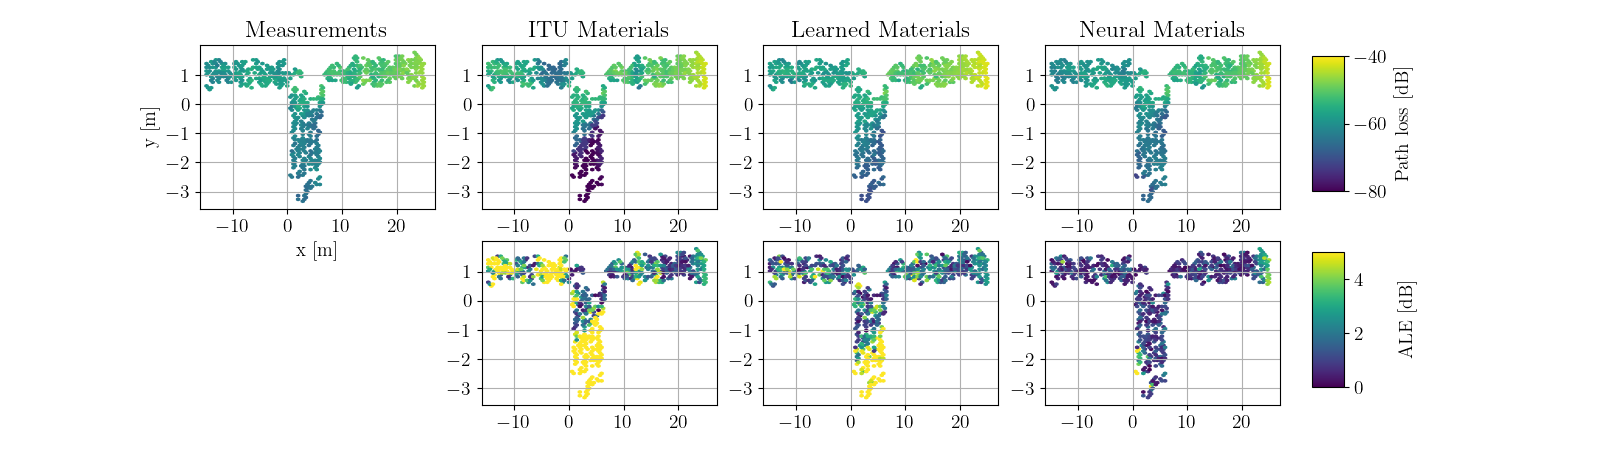

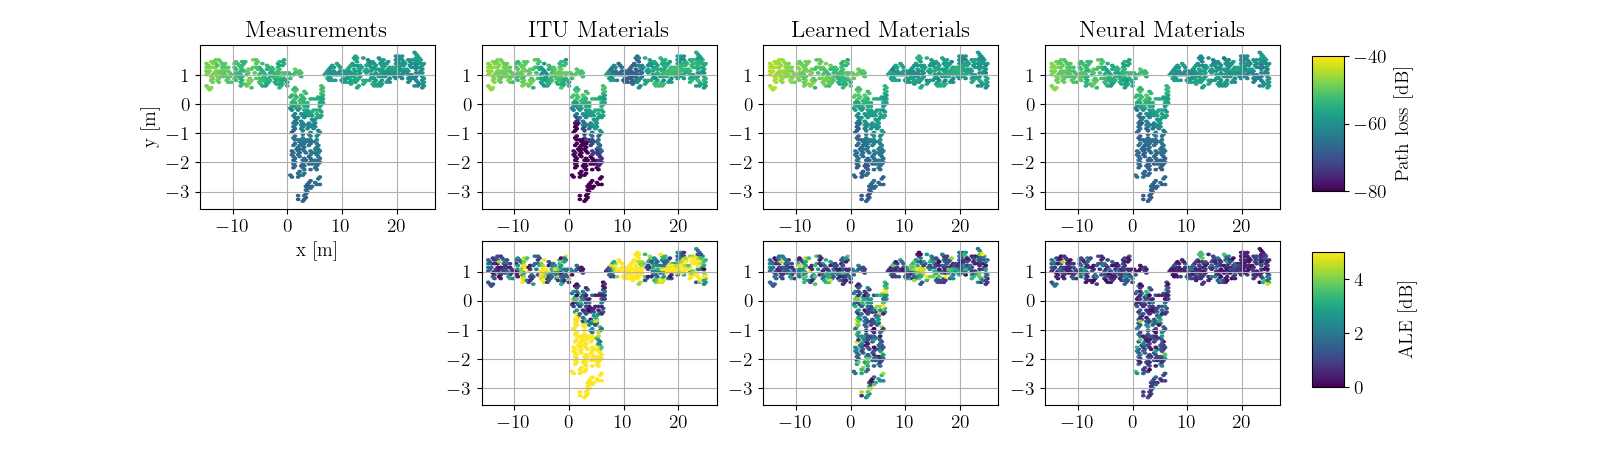

In [4]:
plt.rcParams['font.size'] = 14
plt.rcParams['font.family'] = 'serif'
plt.rcParams['text.usetex'] = False

for tx_ind in (0,1):
    
    num_schemes = len(results)+1
    
    fig, axs = plt.subplots(2,num_schemes, figsize=(num_schemes*4, 4.5))
   
    # RT
    for i, res in enumerate(results.items()):
                
        scheme_name = res[0]
        # rx_pos : [num_samples, 3]
        # pow_rt : [num_samples, num_tx, num_antennas]
        # pow_meas : [num_samples, num_tx, num_antennas]
        rx_pos, pow_rt, _, pow_meas, _ = res[1]
        
        # [num_samples, num_tx]
        err = ale(pow_rt, pow_meas)
        
        # Average the power over the antennas
        # pow_rt : [num_samples, num_tx]
        # pow_meas : [num_samples, num_tx]
        pow_rt = tf.reduce_mean(pow_rt, axis=-1)
        pow_meas = tf.reduce_mean(pow_meas, axis=-1)
        
        if i == 0:
            # Measurements
            pow_meas_db = 10.0*np.log10(pow_meas.numpy())
            axs[0,0].hexbin(rx_pos[:, 1], rx_pos[:, 0], C = pow_meas_db[:,tx_ind], vmin=-80, vmax=-40, gridsize=70)
            axs[0,0].set_title(f"Measurements")
            axs[0,0].grid(True)
            axs[0,0].set_xlabel('x [m]')
            axs[0,0].set_ylabel('y [m]')
            axs[0,0].set_xticks((np.arange(-20, 30, 10.0)))
            axs[0,0].set_yticks((np.arange(-3, 2, 1.0)))
            axs[0,0].set_xlim((-16,27))
            # Remove ticks from the first figure of the second row
            axs[1,0].axis('off')

        pow_rt_db = 10.0*np.log10(pow_rt.numpy())
        im = axs[0,i+1].hexbin(rx_pos[:, 1], rx_pos[:, 0], C = pow_rt_db[:,tx_ind], vmin=-80, vmax=-40, gridsize=70)
        axs[0,i+1].set_title(scheme_name)
        axs[0,i+1].grid(True)
        axs[0,i+1].set_xticks((np.arange(-20, 30, 10.0)))
        axs[0,i+1].set_yticks((np.arange(-3, 2, 1.0)))
        axs[0,i+1].set_xlim((-16,27))

        im_err = axs[1,i+1].hexbin(rx_pos[:, 1], rx_pos[:, 0], C = err[:,tx_ind], vmin=0, vmax=5, gridsize=70)
        axs[1,i+1].grid(True)
        axs[1,i+1].set_xticks((np.arange(-20, 30, 10.0)))
        axs[1,i+1].set_yticks((np.arange(-3, 2, 1.0)))
        axs[1,i+1].set_xlim((-16,27))

    plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
    cax = plt.axes([0.82, 0.575, 0.02, 0.3])
    fig.colorbar(im, cax=cax, label='Path loss [dB]')
    cax = plt.axes([0.82, 0.14, 0.02, 0.3])
    cb = fig.colorbar(im_err, cax=cax)
    cb.set_label('ALE [dB]', labelpad=25)
    plt.savefig(res_folder + f'path_loss_rx{tx_ind+1}.pdf', bbox_inches='tight')